In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12,12

from answers import give_answer
from utils import MDP, visualize

# Use seaborn style plots
sns.set()

# Set random generators seeds
np.random.seed(7)

# Jack’s Car Rental Problem
#####  
![frozen lake](refs/car_rent.jpg)
#####  

>Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he rents it out and is credited \$10 by the national company. If he is out of cars at that location, then the business is lost. Cars become available for renting the day after they are returned. To help ensure that cars are available where they are needed, Jack can move them between the two locations overnight, at a cost of \$2 per car moved. We assume that the number of cars requested and returned at each location are Poisson random variables, meaning that the probability that the number is $n$ is $\frac{λ^n}{n!}e^{−λ}$, where $λ$ is the expected number. Suppose $λ$ is 3 and 4 for rental requests at the first and second locations and $3$ and $2$ for returns. To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. We take the discount rate to be $γ = 0.9$ and formulate this as a continuing finite MDP [...]"~ _Reinforcement Learning: An Introduction 2nd_

`__NOTE__ = "Poisson distribution tells us probability of given number of Poisson processes (independent events) occurring in fixed interval of time, when mean number of Poisson processes occurring in this interval is known."`

## Checklist questions:
* What is STATE in this problem?
* What is ACTION in this problem?
* What is REWARD in this problem?
* What is TRANSITION in this problem?
* What is EPISODE in this problem?

In [3]:
give_answer('checklist questions')

[...] formulate this <problem> as a continuing finite MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight.


In [4]:
mdp = MDP()
T = mdp.get_dynamics(path='data.npy')

STATE_SPACE = T.shape[:2]
print("State space shape: ", STATE_SPACE)
ACTION_SPACE = T.shape[2]
print("Action space size: ", ACTION_SPACE)

# Initialize arbitrary policy and state values
pi = np.zeros(STATE_SPACE, dtype=np.int)
V = np.zeros(STATE_SPACE, dtype=np.float)

State space shape:  (21, 21)
Action space size:  11


# Policy Evaluation

![value interation](refs/policy_eval.png)

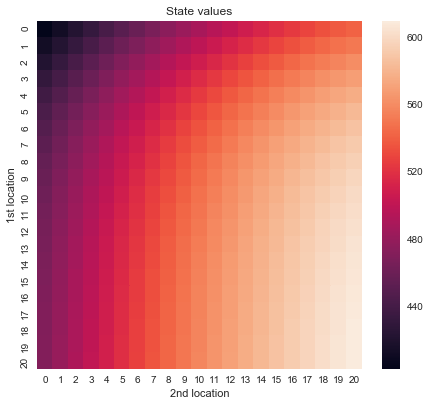

In [6]:
def q_value(n1, n2, action, gamma):
    q = .0
    for n1_, n2_ in mdp.states_iter():
        p, r = T[n1, n2, action, n1_, n2_]
        q += p * (r + gamma * V[n1_, n2_])
    
    return q

def policy_evaluation(gamma, theta):
    while True:
        V_old = np.copy(V)
        for n1, n2 in mdp.states_iter():
            V[n1, n2] = q_value(n1, n2, pi[n1, n2], gamma=gamma)

        max_diff = np.max(np.abs(V_old - V))
        if max_diff < theta:
            break

policy_evaluation(gamma=0.9, theta=1.)
visualize(V=V)

# Policy Improvement

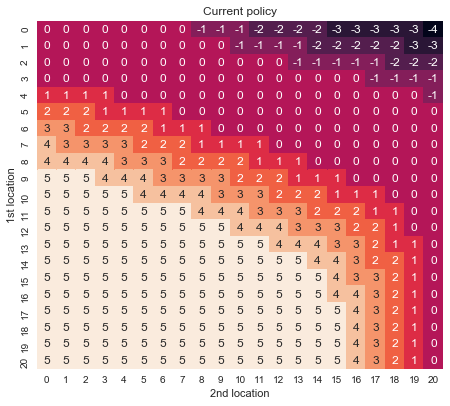

In [7]:
def policy_improvement(gamma):
    changed = False
    for n1, n2 in mdp.states_iter():
        actions = list(mdp.actions_in_state(n1, n2))
        q_values = list(map(lambda action: q_value(n1, n2, action, gamma=gamma), actions))
        
        best_a = actions[np.argmax(q_values)]
        if pi[n1, n2] != best_a:
            pi[n1, n2] = best_a
            changed = True
    return changed

policy_improvement(gamma=0.9)
visualize(pi=pi)

# Policy Iteration

![policy interation](refs/policy_iter.png)

Policy iteration: 1


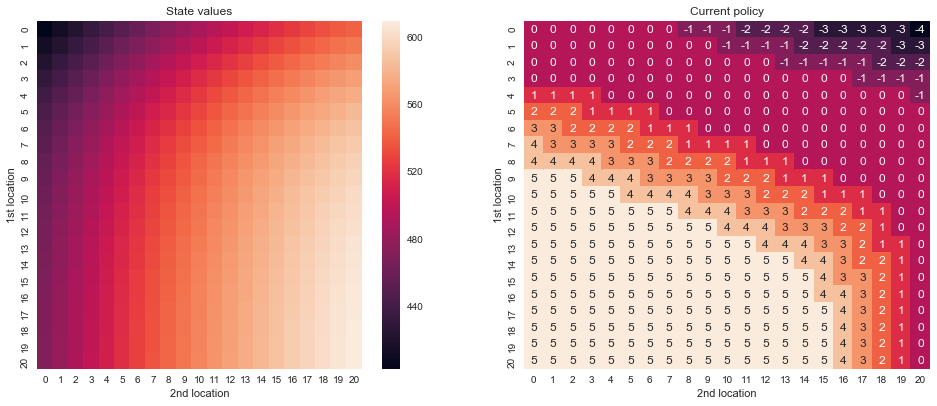

Policy iteration: 2


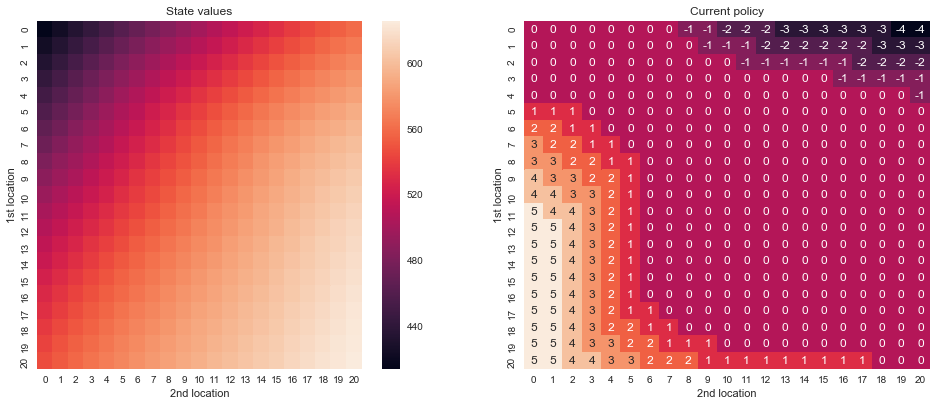

Policy iteration: 3


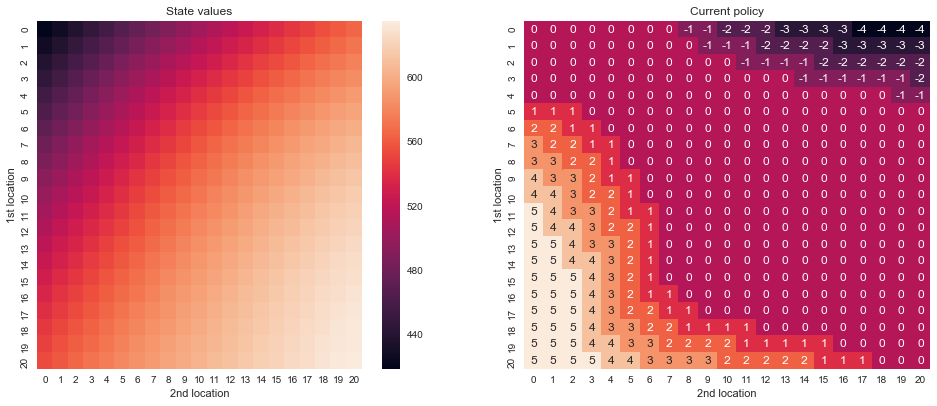

Policy iteration: 4


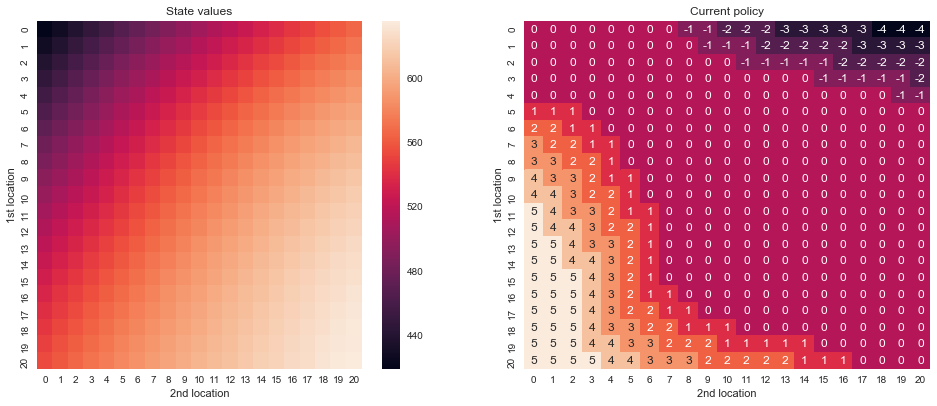

Policy iteration: 5


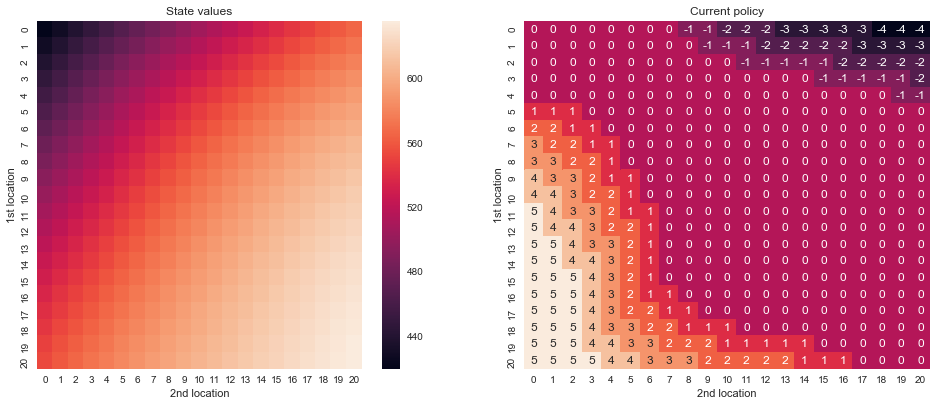

In [10]:
# Initialize arbitrary policy and state values
pi = np.zeros(STATE_SPACE, dtype=np.int)
V = np.zeros(STATE_SPACE, dtype=np.float)

def policy_iteration(gamma=0.9, theta=1.):
    i = 0
    while True:
        policy_evaluation(gamma=gamma, theta=theta)
        changed = policy_improvement(gamma=gamma)

        print("Policy iteration: {}".format(i + 1))
        visualize(pi=pi, V=V)
        plt.pause(0.05)
        
        if not changed:
            break
        i += 1

policy_iteration()

# Value Iteration

By turning Bellman optimality equation into update rule we can interativelly improve value estimation (start from random point e.g. zeros).

![value interation](refs/value_iter.png)

In [9]:
### TODO: Implement Value Iteration algorithm from pseudo-code above.
V = np.zeros(n_states)
iter = 0
while True:
    iter += 1
    delta = 0
    # Start from the end to speed value propagation
    for s in reversed(range(n_states)):
        oldV = V[s]
        V[s] = np.max([sum([p*(r + V[s_]) for p, s_, r, _ in P[s][a]]) for a in range(n_actions)])
        delta = max(delta, abs(oldV - V[s]))
    if delta < 1e-30:
        print("Finished after {} iterations.".format(iter))
        break

### PLOTING LOGIC - DO NOT TOUCH
# Overide value of goal state to make graph nicer
V[-1] = 1

fig = plt.figure(figsize=plt.figaspect(0.4))

ax = fig.add_subplot(1, 2, 1)
sns.heatmap(V.reshape(lake_shape), annot=True, cmap="Blues_r", ax=ax)
ax.set_title("Value Iteration state values")

ax = fig.add_subplot(1, 2, 2)
sns.heatmap(V.reshape(lake_shape), annot=lake_annot[0 if lake_shape[0] == 4 else 1], fmt='s', cmap="Blues_r", ax=ax)
ax.set_title("Frozen Lake map")

NameError: name 'n_states' is not defined

How we can use our learned values to behave optimaly? Like this:

$$\pi(a|s) = \text{argmax}_a\sum_{s'} T(s, a, s')\big[R(s, a, s') + V(s')\big]$$

# How it looks like in AlphaZero (planning)?

![AlphaZero eval function](refs/alphazero_dnn.png)

### Evaluation function

We use evaluation function that returns (estimated) value of the state and then use it to decide what parts of tree are worth to explore. How we get one?

### Training

Well, we look at game outcome (win, draw, lose) and then create dataset from it and all the states in played game. We just classify (using DNN) what is possible game outcome based on current state and past experience (number of wins, loses, draws in the past when this state was encountered). It's valid method and it's called "Direct Evaluation", but it ignores temporal information. So in short, in AlphaZero we don't do Value Iteration, we use simple classification. 

**But still, Value Iteration and TD-Learning concepts are widely utilised across RL domain so it's worth to know the basics! Don't thank me :)**

# References
* This hands-on was inspired by [wagonhelm/Value-Iteration](https://github.com/wagonhelm/Value-Iteration/blob/master/FrozenIce.ipynb).
* Figures come from "Mastering the Game of Go with Deep Neural Networks and Tree Search" paper and "Reinforcement Learning: An Introduction" book.